# Deep Learning for Diabetes Detection Using Kolmogorov-Arnold Networks
## By Erin Gregoire, Daniel Viola, & Dawson Damuth
### July 2025


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import copy
import os

import torch
from torch.utils.data import TensorDataset, DataLoader
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import ROC

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device: {device}')

using device: cuda


### Data Import & Preprocessing

In [4]:
import kagglehub
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
files = os.listdir(path)
data = pd.read_csv(os.path.join(path, files[2]))

In [5]:
numerical_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
                   'HeartDiseaseorAttack', 'PhysActivity', 'Fruits',
                   'NoDocbcCost', 'DiffWalk', 'Sex']
categorical_features = ['Education', 'Income']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bin', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

X_processed = preprocessor.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y, test_size=0.2, random_state=676, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=676, stratify=y_temp)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print('X train:', X_train.shape, '| y train:', y_train.shape)
print('X validation:', X_val.shape, '| y validation:', y_val.shape)
print('X test:', X_test.shape, '| y test:', y_test.shape)

X train: (202944, 30) | y train: (202944,)
X validation: (25368, 30) | y validation: (25368,)
X test: (25368, 30) | y test: (25368,)


In [13]:
print('Number of classes:', len(y_train_tensor.unique()))

Number of classes: 2


### Multi Layer Perceptron Architecture

In [38]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(30, 256)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        self.linear2 = torch.nn.Linear(256, 512)
        self.linear3 = torch.nn.Linear(512, 1)
        self.dropout = nn.Dropout(.2)
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

In [40]:
net = MLP()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.001)

In [27]:
torchinfo.summary(net)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Linear: 1-1                            7,936
├─Linear: 1-2                            131,584
├─Linear: 1-3                            513
├─ReLU: 1-4                              --
├─Sigmoid: 1-5                           --
Total params: 140,033
Trainable params: 140,033
Non-trainable params: 0

In [15]:
# after adding dropout layers
torchinfo.summary(net)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Linear: 1-1                            7,936
├─Linear: 1-2                            131,584
├─Linear: 1-3                            513
├─Dropout: 1-4                           --
├─ReLU: 1-5                              --
├─Sigmoid: 1-6                           --
Total params: 140,033
Trainable params: 140,033
Non-trainable params: 0

### Training the model

In [33]:
net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

In [37]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.3187161233055336, validation = 0.31406716126293394
Accuracy: training = 86.47311573636077%, validation = 86.59334594765058%
Epoch # 2
Loss: training = 0.3139986611555083, validation = 0.3120431448496766
Accuracy: training = 86.63178019552191%, validation = 86.65247555976032%
Epoch # 3
Loss: training = 0.3128440468977258, validation = 0.31257903441112844
Accuracy: training = 86.67514191106906%, validation = 86.68006937874488%
Epoch # 4
Loss: training = 0.31224859081218104, validation = 0.31198746228038365
Accuracy: training = 86.70421397035636%, validation = 86.62093976663513%
Epoch # 5
Loss: training = 0.31151861791389734, validation = 0.3114693672513243
Accuracy: training = 86.75890886155787%, validation = 86.65247555976032%
Epoch # 6
Loss: training = 0.31085867825590197, validation = 0.3126478184707201
Accuracy: training = 86.83873383790602%, validation = 86.55392620624409%
Epoch # 7
Loss: training = 0.3099390798510248, validation = 0.3118982993478152
Acc

### Hyperparameter Tuning

In [39]:
# adding regularization
net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=.001)

In [41]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.31956763084494, validation = 0.31767636567503965
Accuracy: training = 86.43271050141911%, validation = 86.29375591296122%
Epoch # 2
Loss: training = 0.3160865046318813, validation = 0.3139110512320121
Accuracy: training = 86.54505676442763%, validation = 86.68006937874488%
Epoch # 3
Loss: training = 0.3156092538208258, validation = 0.3127577480059772
Accuracy: training = 86.56082466099022%, validation = 86.67612740460423%
Epoch # 4
Loss: training = 0.3150547745004578, validation = 0.3187147243388334
Accuracy: training = 86.56378114159571%, validation = 86.56181015452539%
Epoch # 5
Loss: training = 0.3149946213031627, validation = 0.3128877127889413
Accuracy: training = 86.59088221381268%, validation = 86.64064963733837%
Epoch # 6
Loss: training = 0.314734334274093, validation = 0.3125546689159307
Accuracy: training = 86.60714285714286%, validation = 86.69977924944813%
Epoch # 7
Loss: training = 0.3145929736943744, validation = 0.31378495011796903
Accuracy: 

In [43]:
# adding learning rate scheduler
net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.1)

In [45]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()
            scheduler.step(vloss)

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.3199411511026595, validation = 0.314437206591194
Accuracy: training = 86.45882608010092%, validation = 86.53027436140019%
Epoch # 2
Loss: training = 0.31585848384065857, validation = 0.31442483683027816
Accuracy: training = 86.53076710816777%, validation = 86.53027436140019%
Epoch # 3
Loss: training = 0.3158295794400712, validation = 0.31441231985487533
Accuracy: training = 86.53273809523809%, validation = 86.53027436140019%
Epoch # 4
Loss: training = 0.3158122905134253, validation = 0.3143998769359972
Accuracy: training = 86.53224534847051%, validation = 86.52239041311888%
Epoch # 5
Loss: training = 0.31582211681452554, validation = 0.3143874713823424
Accuracy: training = 86.53421633554083%, validation = 86.51844843897824%
Epoch # 6
Loss: training = 0.31581734540821776, validation = 0.31437511098145243
Accuracy: training = 86.53421633554083%, validation = 86.51844843897824%
Epoch # 7
Loss: training = 0.3157949845152725, validation = 0.31436280756439994
Acc

In [47]:
# reducing batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=.001)

In [49]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.31895958973157673, validation = 0.31600579964724235
Accuracy: training = 86.48789813938821%, validation = 86.52633238725954%
Epoch # 2
Loss: training = 0.3163422174970271, validation = 0.31347997546646394
Accuracy: training = 86.50612976978871%, validation = 86.62882371491642%
Epoch # 3
Loss: training = 0.3158049685454677, validation = 0.31505185178004824
Accuracy: training = 86.57018684957427%, validation = 86.53421633554083%
Epoch # 4
Loss: training = 0.31545717354472674, validation = 0.31353446631047227
Accuracy: training = 86.56181015452539%, validation = 86.67218543046357%
Epoch # 5
Loss: training = 0.3151254418641752, validation = 0.313094263638297
Accuracy: training = 86.59334594765058%, validation = 86.66430148218228%
Epoch # 6
Loss: training = 0.3151908504102028, validation = 0.3128834404708156
Accuracy: training = 86.63572216966257%, validation = 86.65641753390098%
Epoch # 7
Loss: training = 0.3148469211635286, validation = 0.31271136625287516
Acc

In [51]:
# switching up the optimizer
net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.1)

In [53]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()
            scheduler.step(vloss)

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.31907693608227833, validation = 0.3132933108347189
Accuracy: training = 86.50317328918322%, validation = 86.62093976663513%
Epoch # 2
Loss: training = 0.3141125217691012, validation = 0.3132933035155087
Accuracy: training = 86.65001182592242%, validation = 86.62093976663513%
Epoch # 3
Loss: training = 0.3141125167668035, validation = 0.31329329818562235
Accuracy: training = 86.65001182592242%, validation = 86.62093976663513%
Epoch # 4
Loss: training = 0.3141125108340643, validation = 0.31329329278066714
Accuracy: training = 86.65001182592242%, validation = 86.62093976663513%
Epoch # 5
Loss: training = 0.3141125057283842, validation = 0.31329328621214525
Accuracy: training = 86.65001182592242%, validation = 86.62093976663513%
Epoch # 6
Loss: training = 0.3141125004511833, validation = 0.3132932816704815
Accuracy: training = 86.65001182592242%, validation = 86.62093976663513%
Epoch # 7
Loss: training = 0.31411249524682, validation = 0.3132932751770284
Accurac

In [55]:
# switching up optimizer again
net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(net.parameters())

In [57]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()
            scheduler.step(vloss)

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.3181675235035667, validation = 0.31258783284903174
Accuracy: training = 86.52978161463261%, validation = 86.65641753390098%
Epoch # 2
Loss: training = 0.31460169566726504, validation = 0.3121611205321415
Accuracy: training = 86.63424392935983%, validation = 86.64064963733837%
Epoch # 3
Loss: training = 0.31334780464879874, validation = 0.3116596104666328
Accuracy: training = 86.66331598864711%, validation = 86.67218543046357%
Epoch # 4
Loss: training = 0.31257519820480084, validation = 0.31192047518656896
Accuracy: training = 86.70717045096184%, validation = 86.56181015452539%
Epoch # 5
Loss: training = 0.31218002104056214, validation = 0.3117734960629898
Accuracy: training = 86.729344055503%, validation = 86.60517187007252%
Epoch # 6
Loss: training = 0.31155671111626115, validation = 0.3120039803930734
Accuracy: training = 86.78502444023968%, validation = 86.66824345632293%
Epoch # 7
Loss: training = 0.3107113253591903, validation = 0.3116372699476309
Accu

In [19]:
# adding one dropout layer
net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(net.parameters())

In [21]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.3190011710755311, validation = 0.31517221505318455
Accuracy: training = 86.52781062756229%, validation = 86.49479659413434%
Epoch # 2
Loss: training = 0.31470171062447233, validation = 0.3111859041092983
Accuracy: training = 86.62389624724062%, validation = 86.74708293913592%
Epoch # 3
Loss: training = 0.3135994638294019, validation = 0.3121656749266476
Accuracy: training = 86.65789577420372%, validation = 86.72343109429202%
Epoch # 4
Loss: training = 0.3126461490763241, validation = 0.3135951915428267
Accuracy: training = 86.73131504257331%, validation = 86.35288552507096%
Epoch # 5
Loss: training = 0.312223252468046, validation = 0.31208971524657914
Accuracy: training = 86.74018448438979%, validation = 86.56181015452539%
Epoch # 6
Loss: training = 0.3116445951962381, validation = 0.3128779901931034
Accuracy: training = 86.73821349731946%, validation = 86.62488174077578%
Epoch # 7
Loss: training = 0.31091472113793917, validation = 0.31281729521763385
Accur

In [34]:
# adding two dropout layers
net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(net.parameters())

In [36]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.32031452828668255, validation = 0.3134620155970655
Accuracy: training = 86.44157994323557%, validation = 86.71948912015137%
Epoch # 2
Loss: training = 0.3158906949366928, validation = 0.3148711742318455
Accuracy: training = 86.56772311573636%, validation = 86.69977924944813%
Epoch # 3
Loss: training = 0.315009881510936, validation = 0.31239210982718063
Accuracy: training = 86.62340350047305%, validation = 86.73131504257331%
Epoch # 4
Loss: training = 0.3142105094139543, validation = 0.3121090361371112
Accuracy: training = 86.65888126773889%, validation = 86.70766319772942%
Epoch # 5
Loss: training = 0.3137203258888568, validation = 0.31248494286333495
Accuracy: training = 86.65937401450647%, validation = 86.66430148218228%
Epoch # 6
Loss: training = 0.31321998521178246, validation = 0.31225878389636474
Accuracy: training = 86.6899243140965%, validation = 86.62488174077578%
Epoch # 7
Loss: training = 0.3128415574172857, validation = 0.310753057575106
Accurac

In [44]:
# adding xavier weight initialization
net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(net.parameters())

In [46]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.3204382244323722, validation = 0.31667224935550786
Accuracy: training = 86.45488410596026%, validation = 86.67218543046357%
Epoch # 2
Loss: training = 0.31559444314707424, validation = 0.3120941661260835
Accuracy: training = 86.61551955219173%, validation = 86.67612740460423%
Epoch # 3
Loss: training = 0.31495058183261154, validation = 0.31208588796943876
Accuracy: training = 86.60812835067802%, validation = 86.62882371491642%
Epoch # 4
Loss: training = 0.3142058272642867, validation = 0.31140795327610704
Accuracy: training = 86.64951907915483%, validation = 86.66824345632293%
Epoch # 5
Loss: training = 0.3136771290761525, validation = 0.31193478727460505
Accuracy: training = 86.70667770419426%, validation = 86.68006937874488%
Epoch # 6
Loss: training = 0.31312653532282253, validation = 0.3114572513343102
Accuracy: training = 86.69830100914538%, validation = 86.62882371491642%
Epoch # 7
Loss: training = 0.3130394461251147, validation = 0.3117260727750596
Ac

### Save the Best Model

In [48]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

net = MLP().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(net.parameters())

In [50]:
epochs = 10
epoch_number = 0
best_vloss = 1000000

best_train_loss = []
best_val_loss = []
best_train_accuracy = []
best_val_accuracy = []

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)
    best_train_loss.append(avg_loss)
    best_train_accuracy.append(train_acc)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    best_val_loss.append(avg_vloss)
    best_val_accuracy.append(val_acc)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_model = copy.deepcopy(net.state_dict())
        torch.save(best_model, 'project_mlp_dawsonda_dviola_ergregoi.pth')

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.31944409744459834, validation = 0.31265686951596433
Accuracy: training = 86.43123226111636%, validation = 86.68006937874488%
Epoch # 2
Loss: training = 0.31615198360599206, validation = 0.3126738729419876
Accuracy: training = 86.54210028382214%, validation = 86.61699779249447%
Epoch # 3
Loss: training = 0.31540308761149316, validation = 0.3155923055986914
Accuracy: training = 86.58595474613686%, validation = 86.57363607694734%
Epoch # 4
Loss: training = 0.3149221640812114, validation = 0.3124930100792301
Accuracy: training = 86.61601229895932%, validation = 86.61699779249447%
Epoch # 5
Loss: training = 0.31450481027674876, validation = 0.3131069818356776
Accuracy: training = 86.62143251340271%, validation = 86.69189530116682%
Epoch # 6
Loss: training = 0.3140623456472781, validation = 0.3134318658476813
Accuracy: training = 86.66824345632293%, validation = 86.50662251655629%
Epoch # 7
Loss: training = 0.3135325191586561, validation = 0.3151925071811196
Accu

The best model architecture features:
- batch size = 64
- optimizer = AdamW
- Xavier weight initialization
- 2 dropout layers

### Evaluation:

In [56]:
epochs = 1
predictions = []
targets = []
roc_outputs = []

for epoch in range(epochs):
    best_nn_path = torch.load('project_mlp_dawsonda_dviola_ergregoi.pth', weights_only=True)
    net.load_state_dict(best_nn_path)

    running_loss = 0.0
    net.eval() # set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            
            preds = (outputs >= .5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            predictions.append(preds)
            targets.append(labels)
            roc_outputs.append(outputs)

    test_acc = (correct / total) * 100
    avg_test_loss = running_loss / len(test_loader)

print(f'Test Loss: {avg_test_loss}')
print(f'Test Accuracy: {test_acc}%')

Test Loss: 0.314045506625692
Test Accuracy: 86.69583727530747%


In [58]:
print(f'Best Model Loss: Training = {best_train_loss[-1]}, Validation = {best_val_loss[-1]}, Test = {avg_test_loss}')
print(f'Best Model Accuracy: Training = {best_train_accuracy[-1]}%, Validation = {best_val_accuracy[-1]}%, Test = {test_acc}%')

Best Model Loss: Training = 0.31260097312771234, Validation = 0.3140358323189113, Test = 0.314045506625692
Best Model Accuracy: Training = 86.70372122358877%, Validation = 86.67612740460423%, Test = 86.69583727530747%


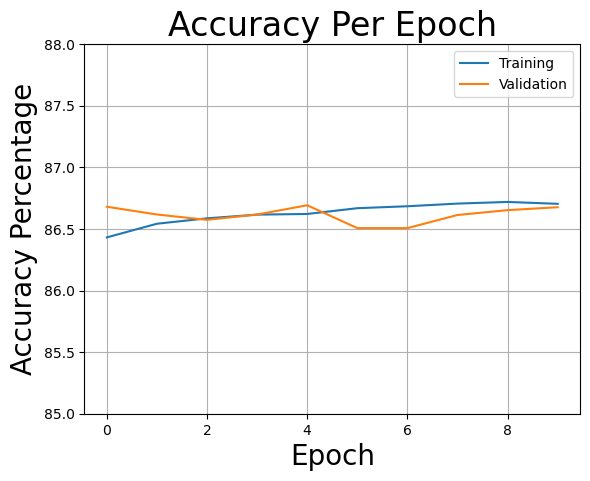

In [74]:
plt.figure()
plt.plot(best_train_accuracy, label = 'Training')
plt.plot(best_val_accuracy, label = 'Validation')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy Percentage', fontsize=20)
plt.title('Accuracy Per Epoch', fontsize=24)
plt.ylim(ymin=85, ymax=88)
plt.legend() 
plt.grid()
plt.show()

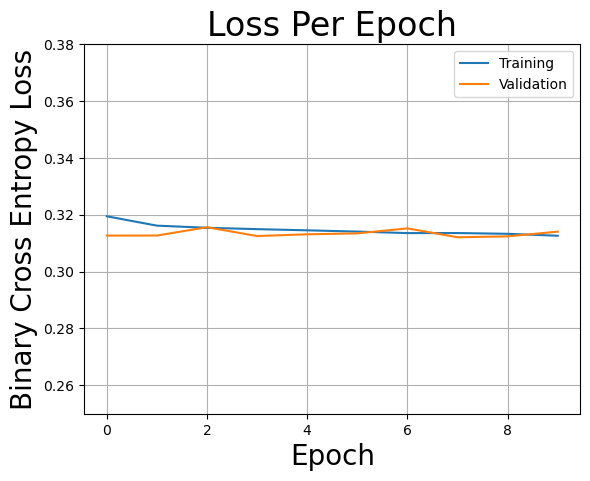

In [82]:
plt.figure()
plt.plot(best_train_loss, label = 'Training')
plt.plot(best_val_loss, label = 'Validation')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Binary Cross Entropy Loss', fontsize=20)
plt.title('Loss Per Epoch', fontsize=24)
plt.ylim(ymin=.25, ymax=.38)
plt.legend() 
plt.grid()
plt.show()

In [64]:
preds2 = torch.cat(predictions)
preds2 = preds2.to('cpu')
targets2 = torch.cat(targets)
targets2 = targets2.to('cpu')

In [66]:
scores = precision_recall_fscore_support(targets2, preds2, average='macro')
print(f'Precision: {scores[0]}, Recall: {scores[1]}, F1 Score: {scores[2]}')

Precision: 0.7275704714031563, Recall: 0.5759745557297451, F1 Score: 0.5961803129872598


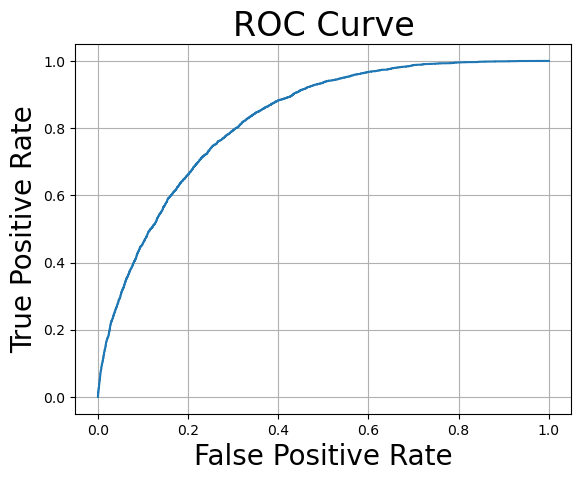

In [68]:
roc_outputs2 = torch.cat(roc_outputs)
roc_outputs2 = roc_outputs2.to('cpu')
targets3 = targets2.long()
roc = ROC(task="binary")
fpr, tpr, thresholds = roc(roc_outputs2, targets3)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=24)
plt.grid()
plt.show()